# Data Generation

In [11]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

dim_theta = 10
data_num = 1000
scale = .1

theta_true = np.ones((dim_theta,1))
print('True theta:', theta_true.reshape(-1))

A = np.random.uniform(low=-1.0, high=1.0, size=(data_num,dim_theta))
y_data = A @ theta_true + np.random.normal(loc=0.0, scale=scale, size=(data_num, 1))

A_test = np.random.uniform(low=-1.0, high=1.0, size=(50, dim_theta))
y_test = A_test @ theta_true + np.random.normal(loc=0.0, scale=scale, size=(50, 1))

True theta: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Solving for the exact mean squared loss (solving Ax = b)

In [12]:
theta_pred = la.inv(A.T @ A) @ A.T @ y_data
print('Empirical theta', theta_pred.reshape(-1))

Empirical theta [1.00541177 0.99591332 0.99545202 0.99995305 1.0024883  0.9972724
 0.99795627 0.99676465 0.99342696 0.99697566]


In [13]:
error = np.linalg.norm(theta_pred - theta_true) / np.linalg.norm(theta_true)
print('Error:', error)

Error: 0.0038379904198865707


# SGD Variants Noisy Function

In [23]:
batch_size = 1
max_iter = 1000
lr = 0.001
theta_init = np.random.random((10,1)) * 0.1

In [24]:
def noisy_val_grad(theta_hat, data_, label_, deg_=2.):
    gradient = np.zeros_like(theta_hat)
    loss = 0

    for i in range(data_.shape[0]):
        x_ = data_[i, :].reshape(-1,1)
        y_ = label_[i, 0]
        err = np.sum(x_ * theta_hat) - y_

        '''
        Hints:
        1. Find the gradient and loss for each data point x_.
        2. For grad, you need err, deg_, and x_.
        3. For l, you need err and deg_ only.
        4. Checkout the writeup for more hints.
        '''
        grad = deg_ * np.sign(err) * np.abs(err)**(deg_-1) * x_
        l = np.abs(err)**deg_

        loss += l / data_.shape[0]
        gradient += grad / data_.shape[0]

    return loss, gradient

# Running SGD Variants

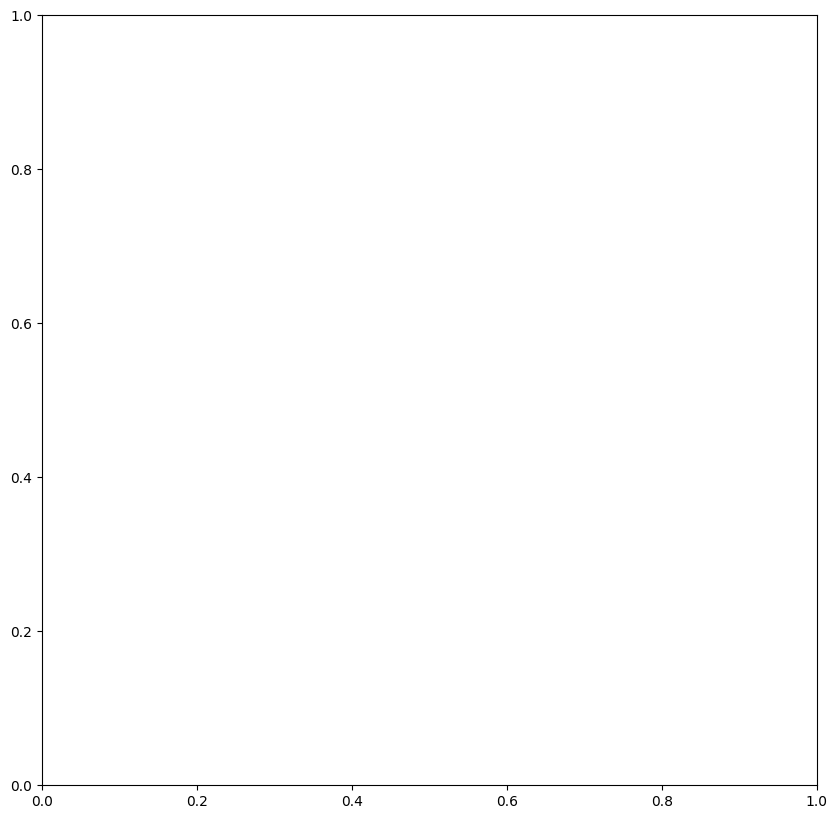

In [54]:
#@title Parameters
deg_ = 5 #@param {type: "number"}
num_rep = 30 #@param {type: "integer"}
max_iter = 1000 #@param {type: "integer"}
fig, ax = plt.subplots(figsize=(10,10))
best_vals = {}
test_exp_interval = 50 #@param {type: "integer"}
grad_artificial_normal_noise_scale = 0. #@param {type: "number"}

adam 0
adam 20
adam done
test_loss_np is a 2d array with num_rep rows and each column denotes a specific update stage in training
The elements of test_loss_np are the test loss values computed in each replicate and training stage.
sgd 0
sgd 20
sgd done
test_loss_np is a 2d array with num_rep rows and each column denotes a specific update stage in training
The elements of test_loss_np are the test loss values computed in each replicate and training stage.
adagrad 0
adagrad 20
adagrad done
test_loss_np is a 2d array with num_rep rows and each column denotes a specific update stage in training
The elements of test_loss_np are the test loss values computed in each replicate and training stage.


Text(0.5, 0, 'Updates')

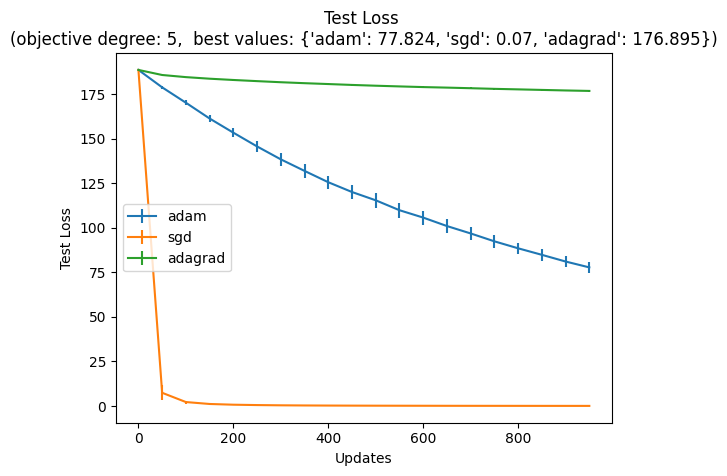

In [55]:
for method_idx, method in enumerate(['adam', 'sgd', 'adagrad']):
    test_loss_mat = []
    train_loss_mat = []

    for replicate in range(num_rep):
        if replicate % 20 == 0:
            print(method, replicate)

        if method == 'adam':
            beta_1 = 0.9
            beta_2 = 0.999
            m = np.zeros_like(theta_init)
            v = np.zeros_like(theta_init)
            epsilon = 1e-8

        if method == 'adagrad':
            epsilon = 1e-8
            squared_sum = np.zeros_like(theta_init)

        theta_hat = theta_init.copy()
        test_loss_list = []

        train_loss_list = []

        for t in range(max_iter):
            idx = np.random.choice(data_num, batch_size)
            train_loss, gradient = noisy_val_grad(theta_hat, A[idx,:], y_data[idx,:], deg_=deg_)
            artificial_grad_noise = np.random.randn(10, 1) * grad_artificial_normal_noise_scale + np.sign(np.random.random((10, 1)) - 0.5) * 0.
            gradient = gradient + artificial_grad_noise
            train_loss_list.append(train_loss)

            if t % test_exp_interval == 0:
                test_loss, _ = noisy_val_grad(theta_hat, A_test[:,:], y_test[:,:], deg_=deg_)
                test_loss_list.append(test_loss)

            if method == 'adam':
                m = beta_1 * m + (1 - beta_1) * gradient
                v = beta_2 * v + (1 - beta_2) * (gradient**2)
                m_hat = m / (1 - beta_1**(t+1))
                v_hat = v / (1 - beta_2**(t+1))
                theta_hat = theta_hat - lr * m_hat / (np.sqrt(v_hat) + epsilon)

            elif method == 'adagrad':
                squared_sum = squared_sum + gradient**2
                theta_hat = theta_hat - lr * gradient / (np.sqrt(squared_sum) + epsilon)

            elif method == 'sgd':
                theta_hat = theta_hat - lr * gradient

        test_loss_mat.append(test_loss_list)
        train_loss_mat.append(train_loss_list)

    print(method, 'done')
    x_axis = np.arange(max_iter)[::test_exp_interval]

    print('test_loss_np is a 2d array with num_rep rows and each column denotes a specific update stage in training')
    print('The elements of test_loss_np are the test loss values computed in each replicate and training stage.')
    test_loss_np = np.array(test_loss_mat)

    '''
    Hints:
    1. Use test_loss_np in np.mean() with axis = 0
    '''
    test_loss_mean = np.mean(test_loss_np, axis=0)

    '''
    Hints:
    1. Use test_loss_np in np.std() with axis = 0
    2. Divide by np.sqrt() using num_rep as a parameter
    '''
    test_loss_se = np.std(test_loss_np, axis=0) / np.sqrt(num_rep)

    plt.errorbar(x_axis, test_loss_mean, yerr=2.5*test_loss_se, label=method)
    best_vals[method] = min(test_loss_mean)

best_vals = { k: int(v * 1000) / 1000. for k,v in best_vals.items() } # A weird way to round numbers
plt.title(f'Test Loss \n(objective degree: {deg_},  best values: {best_vals})')
plt.ylabel('Test Loss')
plt.legend()
plt.xlabel('Updates')

Text(0.5, 0, 'Updates')

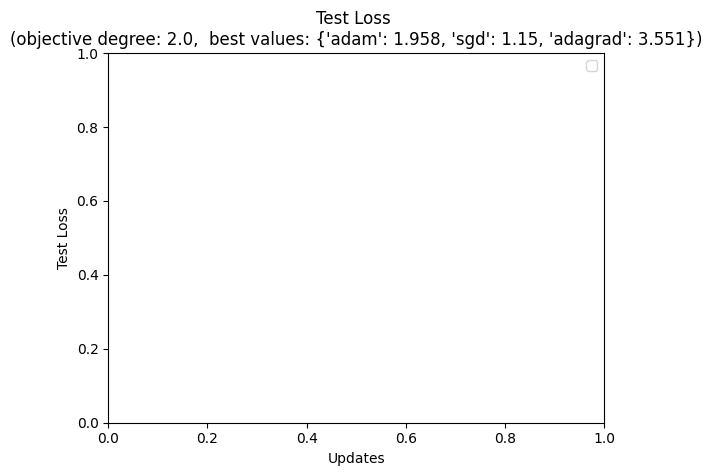

In [28]:
best_vals = { k: int(v * 1000) / 1000. for k,v in best_vals.items() } # A weird way to round numbers
plt.title(f'Test Loss \n(objective degree: {deg_},  best values: {best_vals})')
plt.ylabel('Test Loss')
plt.legend()
plt.xlabel('Updates')